In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [4]:
# DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv --no-check-certificate

--2022-10-17 12:48:15--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3%  583K 2s
    50K .......... .......... .......... .......... ..........  7% 1.89M 1s
   100K .......... .......... .......... .......... .......... 10% 1.07M 1s
   150K .......... .......... .......... .......... .......... 14% 2.94M 1s
   200K .......... .......... .......... .......... .......... 17% 1.09M 1s
   250K .......... .......... .......... .......... .......... 21% 2.65M 1s
   300K .......... .......... .......... .......... .......... 25% 3.

In [15]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [16]:
df['median_house_value'] = np.log1p(df['median_house_value'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [20]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)


In [22]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [23]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

In [24]:
train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')

In [25]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)
X_val = dv.fit_transform(val_dict)

### Question 1

In [26]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [32]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



______________________________
Answer: ocean_proximity=INLAND

### Question 2

In [33]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [34]:
y_pred = rf.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE  - {RMSE}')

RMSE  - 0.24573834331838426


### Question 3

In [37]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

In [38]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])


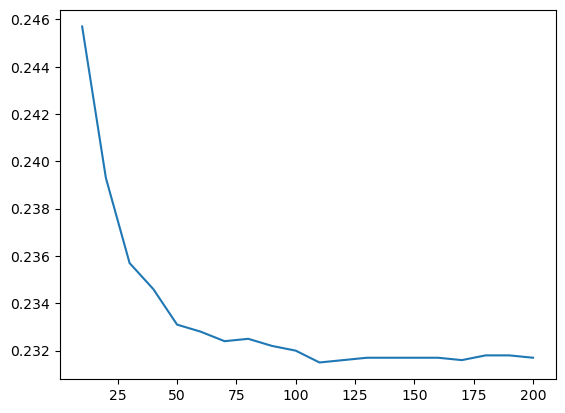

In [41]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(4))

### Question 4

In [42]:
'''
    max_depth:
    Try different values of max_depth: [10, 15, 20, 25].
    For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
    Fix the random seed: random_state=1.
'''
scores = []

for d in [10, 15, 20, 25]:
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

In [43]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

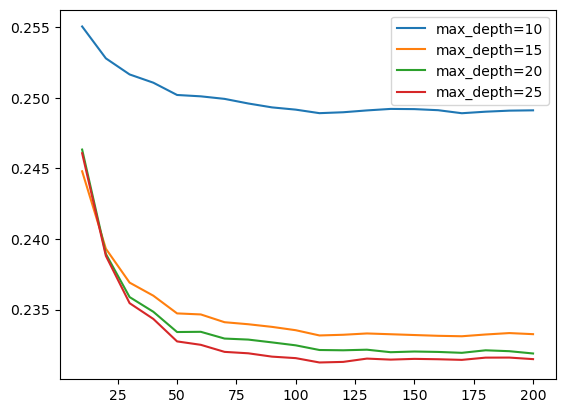

In [49]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
plt.legend()

Answer: 25

### Question 5

In [45]:
"""
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
"""
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [46]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [52]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances = df_importances.sort_values(by='importance', ascending=False)
df_importances

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


Answer: median_income - 0.362913

### Question 6

In [54]:
"""
    Install XGBoost.
    Create DMatrix for train and validation
    Create a watchlist
    Train a model with these parameters for 100 rounds:
    
"""
xgb_params = {  
        'eta': 0.3,  
        'max_depth': 6,  
        'min_child_weight': 1,  

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [58]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [61]:
%%capture output
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)


In [62]:
scores['eta=0.3'] = parse_xgb_output(output)

In [63]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,8.12733,8.13245
1,5,1.40218,1.40741
2,10,0.34481,0.35782
3,15,0.23555,0.26044
4,20,0.21580,0.24624
5,25,0.20395,0.24099
6,30,0.19440,0.23741
7,35,0.18637,0.23562
8,40,0.17983,0.23419
9,45,0.17468,0.23279


In [64]:
%%capture output

xgb_params = {  
        'eta': 0.1,  
        'max_depth': 6,  
        'min_child_weight': 1,  

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [67]:
scores['eta=0.1'] = parse_xgb_output(output)
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,10.44371,10.44938
1,5,6.17513,6.17987
2,10,3.65741,3.66135
3,15,2.17500,2.17928
4,20,1.30499,1.31054
5,25,0.79933,0.80657
6,30,0.51144,0.52189
7,35,0.35700,0.37263
8,40,0.27985,0.30053
9,45,0.24350,0.26829


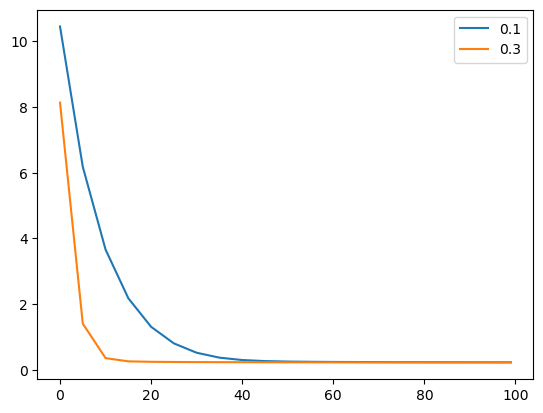

In [68]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

Answer: 0.3